# Multimodal Tasks and Models

- **Visual Question Answering (VQA) and Visual Reasoning:** Teach machines to answer questions about images, going beyond recognition to infer relationships and understand context.
- **Document Visual Question Answering (DocVQA):** Enables computers to understand and answer questions about documents by combining computer vision and natural language processing.
- **Image captioning:** Bridges vision and language by crafting descriptive sentences for images, allowing computers to narrate the visual world.
- **Image-Text Retrieval:** Acts as a matchmaker for images and their descriptions, enabling powerful applications like image search and automatic captioning.
- **Visual grounding:** Links language with specific parts of an image, allowing AI to pinpoint objects based on natural language descriptions.
- **Text-to-Image generation:** Transforms written descriptions into unique images, creating visual worlds from the power of words.


###  Visual Question Anwering (VQA) and Visual Reasoning
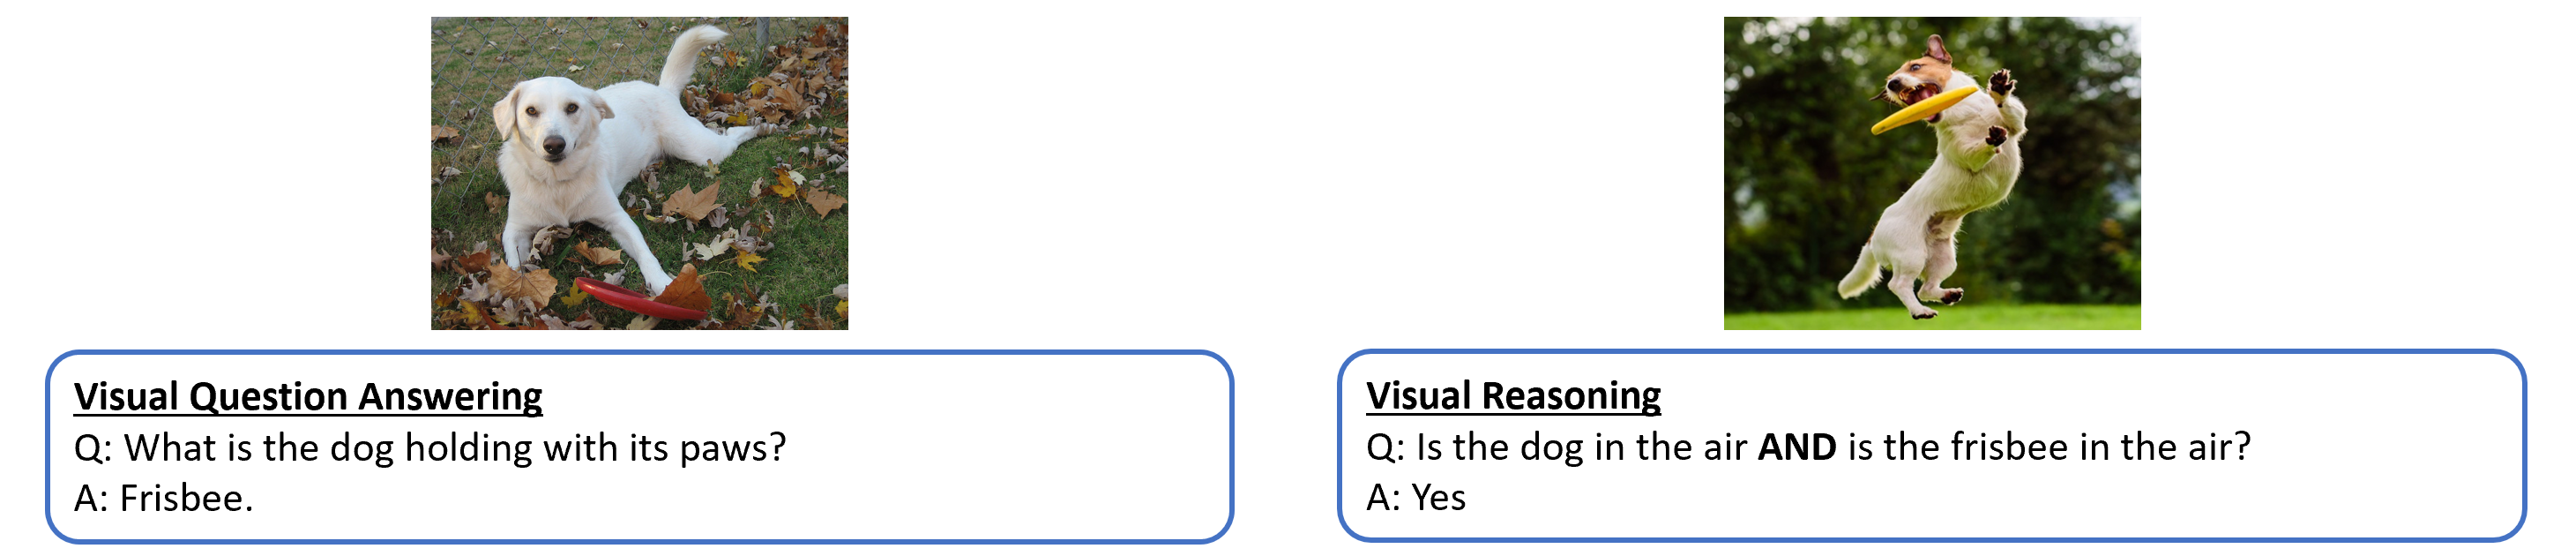

 **BLIP-VQA:** It is a large pre-trained model for visual question answering (VQA) tasks developed by Salesforce AI. It uses a “Bootstrapping Language-Image Pre-training” (BLIP) approach, which leverages both noisy web data and caption generation to achieve state-of-the-art performance on various vision-language tasks. You can use the BLIP in huggingface as follows:

In [ ]:
from PIL import Image
from transformers import pipeline

vqa_pipeline = pipeline(
    "visual-question-answering", model="Salesforce/blip-vqa-capfilt-large"
)

image = Image.open("elephant.jpeg")
question = "Is there an elephant?"

vqa_pipeline(image, question, top_k=1)



**DePlot** is a one-shot visual language reasoning model designed to translate plots and charts into text summaries. By integrating with large language models (LLMs), it can answer complex questions about the data, even with novel human-written queries. DePlot accomplishes this by standardizing the plot-to-table translation task and utilizing the Pix2Struct architecture, surpassing previous state-of-the-art results on chart question answering with just a single example and LLM prompting.

In [ ]:
## Deplot in huggingface
from transformers import Pix2StructProcessor, Pix2StructForConditionalGeneration
import requests
from PIL import Image

processor = Pix2StructProcessor.from_pretrained("google/deplot")
model = Pix2StructForConditionalGeneration.from_pretrained("google/deplot")

url = "https://raw.githubusercontent.com/vis-nlp/ChartQA/main/ChartQA%20Dataset/val/png/5090.png"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(
    images=image,
    text="Generate underlying data table of the figure below:",
    return_tensors="pt",
)
predictions = model.generate(**inputs, max_new_tokens=512)
print(processor.decode(predictions[0], skip_special_tokens=True))

**VLIT** is a Vision-and-Language Transformer (ViLT) model fine-tuned on the VQAv2 dataset for answering natural language questions about images. It utilizes a transformer architecture without convolutions or region supervision, boasting a large architecture (B32 size) and leveraging joint image and text training. This makes it effective for various vision-language tasks, particularly VQA, achieving competitive performance.

In [ ]:
# VLIT in HuggingFace 
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from PIL import Image

# prepare image + question
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
text = "How many cats are there?"

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# prepare inputs
encoding = processor(image, text, return_tensors="pt")

# forward pass
outputs = model(**encoding)
logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])

###  Document Visual Question Answering (DocVQA)
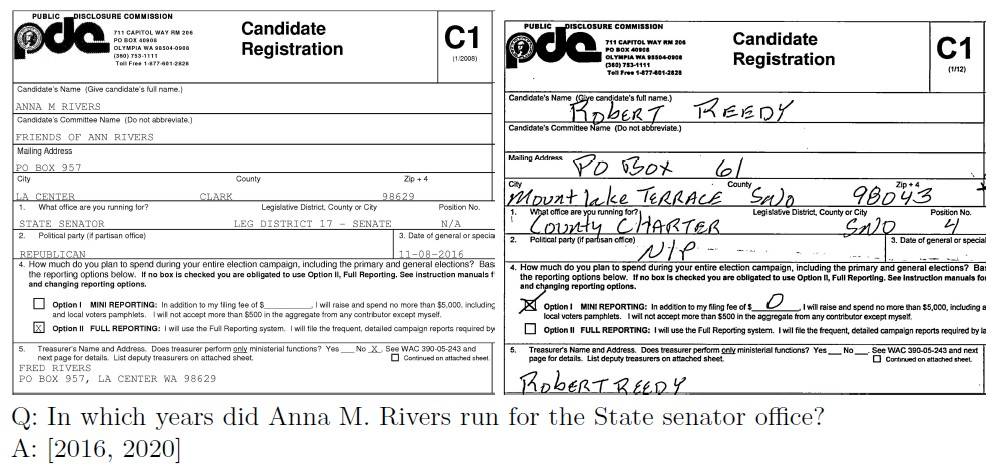

**LayoutLM** is a pre-trained neural network designed to understand document images by analyzing both text and layout. Unlike traditional NLP models, it considers factors like font size and position to learn relationships between words and their meaning in the context of the document. This enables it to excel at tasks such as form understanding, receipt analysis, and document classification, making it a powerful tool for extracting information from scanned documents.

In [ ]:
## LayoutLM in HuggingFace
from transformers import pipeline
from PIL import Image

pipe = pipeline("document-question-answering", model="impira/layoutlm-document-qa")

question = "What is the purchase amount?"
image = Image.open("your-document.png")

pipe(image=image, question=question)


**Donut**, also known as OCR-free Document Understanding Transformer, is an advanced image processing model that analyzes document images directly, bypassing traditional optical character recognition (OCR). It combines a vision encoder (Swin Transformer) with a text decoder (BART) to extract information and generate textual descriptions. Donut excels in tasks such as document classification, form understanding, and visual question answering, leveraging its "end-to-end" approach to achieve impressive accuracy with efficient processing.

In [ ]:
## Donut in HuggingFace
from transformers import pipeline
from PIL import Image

pipe = pipeline(
    "document-question-answering", model="naver-clova-ix/donut-base-finetuned-docvqa"
)

question = "What is the purchase amount?"
image = Image.open("your-document.png")

pipe(image=image, question=question)

**Nougat** is a visual transformer model trained on millions of academic papers, capable of directly extracting content from scanned PDFs in a structured markup language. By bypassing traditional Optical Character Recognition, it achieves high accuracy while preserving semantics, making scientific knowledge stored in PDFs more accessible. Using the same architecture as Donut, it employs an image Transformer encoder and an autoregressive text Transformer decoder to translate scientific PDFs to markdown, facilitating easier access to information.

In [ ]:
## Nougat in huggingFace
from huggingface_hub import hf_hub_download
import re
from PIL import Image

from transformers import NougatProcessor, VisionEncoderDecoderModel
from datasets import load_dataset
import torch

processor = NougatProcessor.from_pretrained("facebook/nougat-base")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-base")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
# prepare PDF image for the model
filepath = hf_hub_download(
    repo_id="hf-internal-testing/fixtures_docvqa",
    filename="nougat_paper.png",
    repo_type="dataset",
)
image = Image.open(filepath)
pixel_values = processor(image, return_tensors="pt").pixel_values

# generate transcription (here we only generate 30 tokens)
outputs = model.generate(
    pixel_values.to(device),
    min_length=1,
    max_new_tokens=30,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
)

sequence = processor.batch_decode(outputs, skip_special_tokens=True)[0]
sequence = processor.post_process_generation(sequence, fix_markdown=False)
# note: we're using repr here such for the sake of printing the \n characters, feel free to just print the sequence
print(repr(sequence))

###  Image Captioning
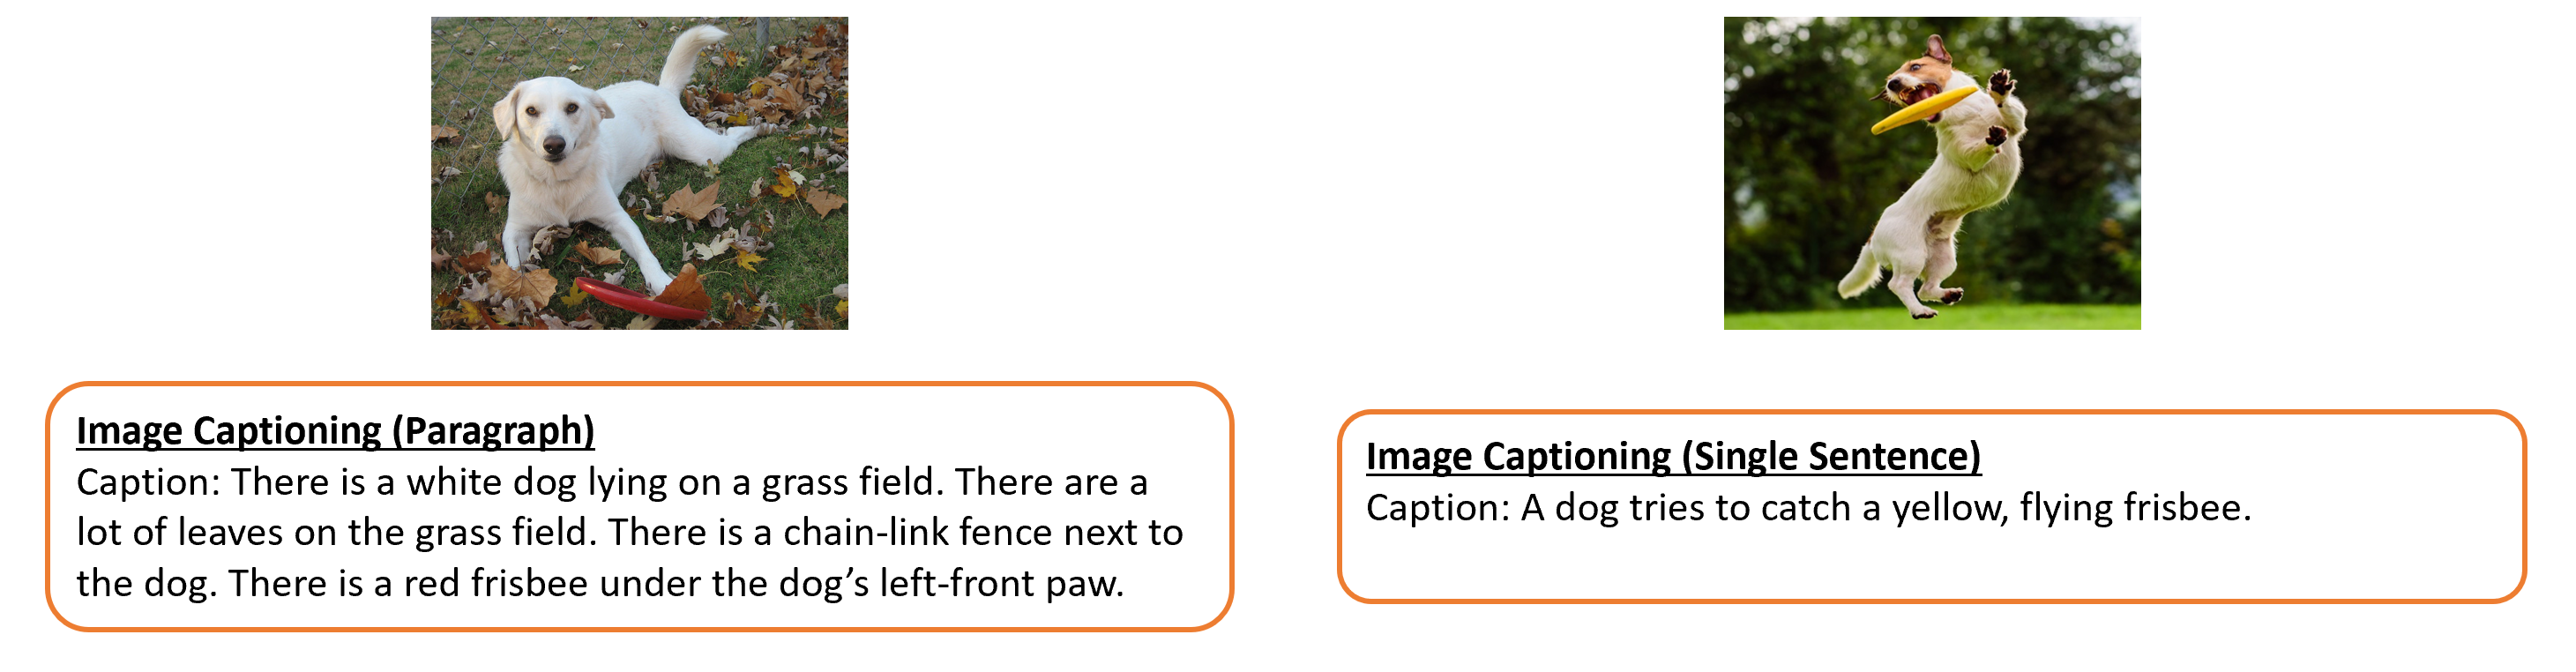

**ViT-GPT2** is a PyTorch model designed for generating image captions by combining Vision Transformer (ViT) for visual feature extraction with GPT-2 for text generation. Trained on the COCO dataset, it utilizes ViT's capacity to encode detailed image information and GPT-2's proficiency in language production to generate accurate and descriptive captions. This open-source model provides an effective solution for tasks involving image understanding and captioning.

In [ ]:
##  ViT-GPT2 in HuggingFace
from transformers import pipeline

image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

image_to_text("https://ankur3107.github.io/assets/images/image-captioning-example.png")



**BLIP-Image-Captioning** is a cutting-edge model for generating image captions, built on the BLIP framework. Utilizing pre-training on both clean and noisy web data, it employs a bootstrapping process to filter out noisy captions, leading to enhanced performance in tasks such as image captioning, image-text retrieval, and visual question answering (VQA). This large version, featuring a ViT-L backbone, excels in producing accurate and detailed captions from images.

In [ ]:
#BLIP Image Captioning model in HuggingFace
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-large"
)

img_url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

# conditional image captioning
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

**git-base**: part of microsoft/git-base, is a base-sized version of the GIT (Generative Image to Text) model. It is a Transformer decoder trained to generate text descriptions of images by taking both image tokens and text tokens as input. This enables it to predict the next text token based on both the image and previous text, making it suitable for tasks like image and video captioning. Fine-tuned versions like microsoft/git-base-coco and microsoft/git-base-textcaps are available for specific datasets, while the base model serves as a starting point for further customization.


In [ ]:
##git-base model in HuggingFace

from transformers import AutoProcessor, AutoModelForCausalLM
import requests
from PIL import Image

processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pixel_values = processor(images=image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

### Image-Text Retrieval
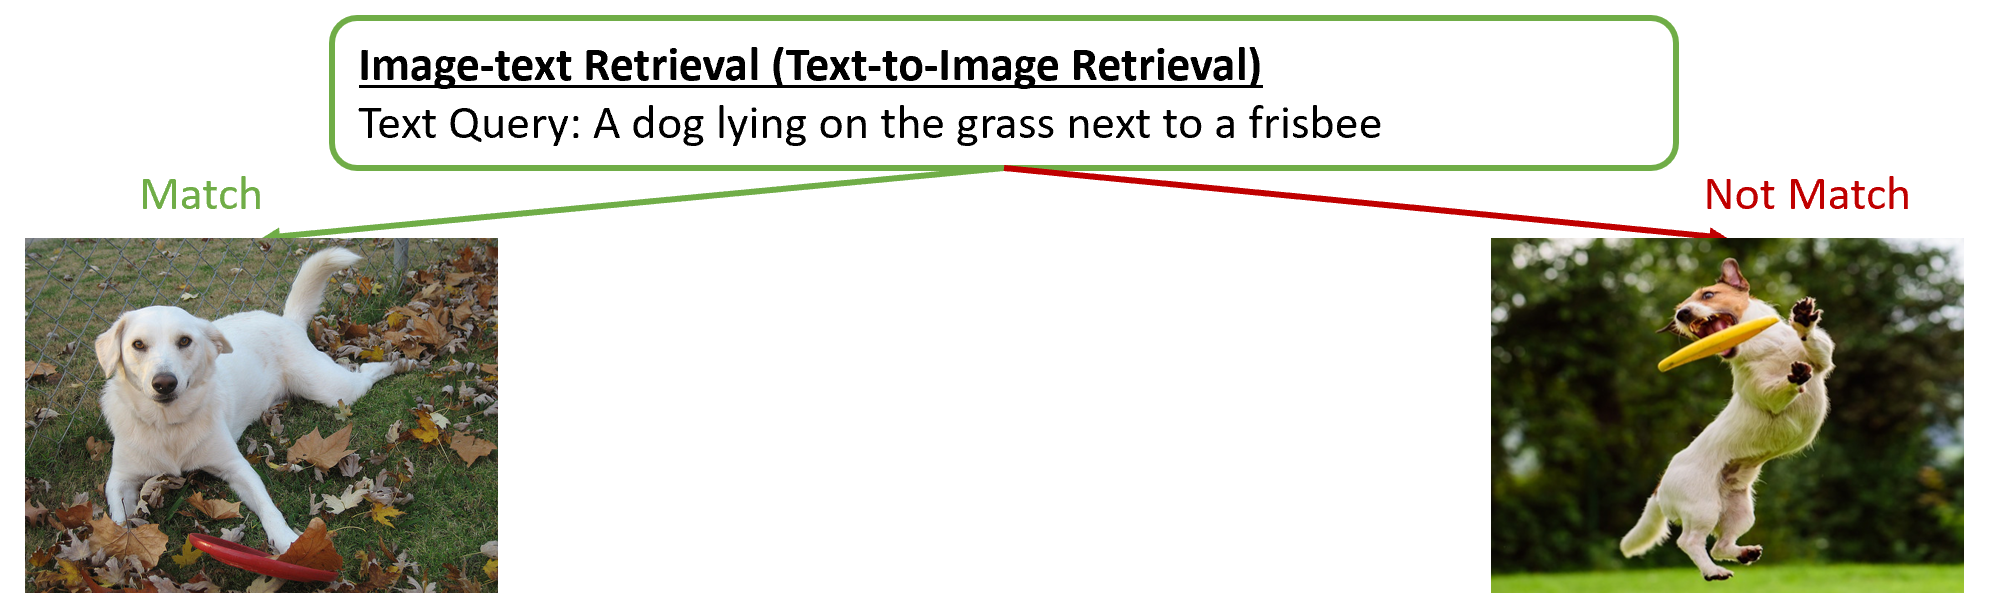

**CLIP (Contrastive Language-Image Pretraining)** excels in image-text retrieval through a shared embedding space achieved via contrastive learning on large-scale image and text datasets. By mapping diverse concepts into a common space during pretraining, CLIP enables direct comparison between images and text, facilitating efficient and accurate retrieval tasks. Its versatility lies in its ability to understand semantic relationships without task-specific fine-tuning, making it efficient for various applications such as content-based image retrieval and interpreting natural language queries for images.

In [ ]:
## CLIP in HuggingFace for Image-Text retrieval 
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(
    text=["a photo of a cat", "a photo of a dog"],
    images=image,
    return_tensors="pt",
    padding=True,
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(
    dim=1
)  # we can take the softmax to get the label probabilities

### Visual Grounding
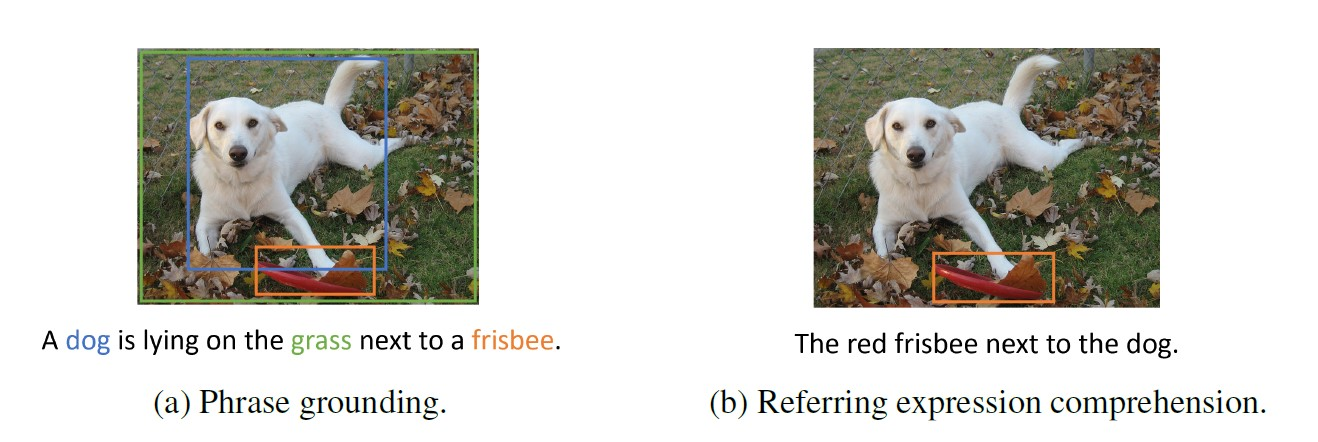

**OWL-ViT (Vision Transformer for Open-World Localization)** is an advanced object detection model trained on large-scale image-text pairs. It stands out for its ability to perform "open-vocabulary" detection, meaning it can identify objects not present in its training data based on textual descriptions. Leveraging contrastive pre-training and fine-tuning, OWL-ViT achieves remarkable performance in both zero-shot and one-shot detection tasks, making it a versatile tool for flexible search and identification in images.

In [ ]:
## OWL-ViT in HuggingFace

import requests
from PIL import Image
import torch

from transformers import OwlViTProcessor, OwlViTForObjectDetection

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
texts = [["a photo of a cat", "a photo of a dog"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process_object_detection(
    outputs=outputs, threshold=0.1, target_sizes=target_sizes
)

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Print detected objects and rescaled box coordinates
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}"
    )

### Text-to-Image Generation
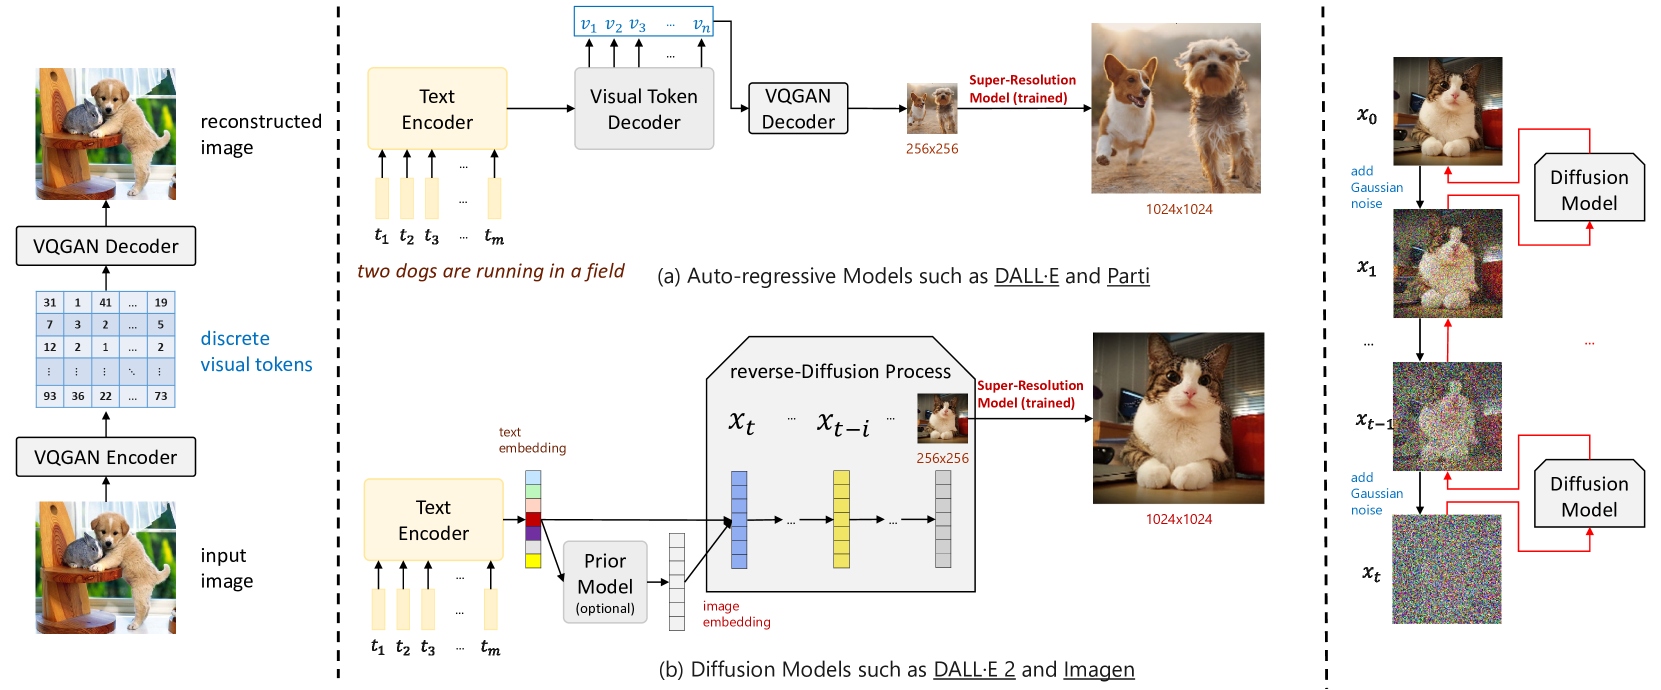

-**Auto-regressive Models** treat the task of generating images as translating text descriptions into sequences of image tokens, employing an encoder-decoder architecture. The encoder extracts information from the text prompt, guiding the decoder to predict image tokens gradually, assembling the final image pixel by pixel. This method offers high control and detail but faces challenges with long, complex prompts and can be slower than alternative methods like diffusion models.

-**Stable Diffusion Models** utilize the "Latent Diffusion" technique to progressively build images from noise, guided by a text prompt and a frozen CLIP text encoder. With a light architecture and latent focus, it enables GPU-powered image generation and diverse artistic expression, producing photorealistic and imaginative visuals from textual inputs.

In [ ]:
#pip install diffusers --upgrade
#pip install invisible_watermark transformers accelerate safetensors

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
pipe.to("cuda")

prompt = "An astronaut riding a unicorn"

images = pipe(prompt=prompt).images[0]